### LangGraph Crash Course
LangGraph is a framework designed for building complex , stateful LLM and multi-agent applications.

### 1 - State

In [36]:
from typing_extensions import TypedDict

class State(TypedDict):
  graph_state: str

### 2 - Nodes 

In [38]:
def node1(state):
    """ Node 1 correspondiente """
    print("--Node 1---")
    return {"graph_state":state['graph_state'] + " Welcome"}

def node2(state):
    """ Node 2 """
    print("--- Node 2---")
    return {"graph_state":state['graph_state'] + "to the DataHack Summit!"}

def node3(state):
    """ Node 3"""
    print("---Node 3---")
    return {"graph_state": state['graph_state'] + "to Bengaluru!"}




###  3 - Edges

In [3]:
import random 
from typing import Literal 

def decide_node(state) -> Literal["node2","node3"]:
    """ dedice node """
    user_input = state["graph_state"]
    if random.random() < 0.5:
        return "node2"
    return "node3"



### 4 - Graph Construction

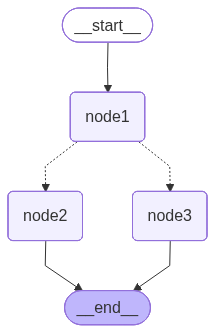

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)

# Defining the nodes
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Define edges with string node names
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_node)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"graph_state": "Hi there "})

--Node 1---
---Node 3---


{'graph_state': 'Hi there  Welcometo Bengaluru!'}

### 5 - Build LLM Application with LangGraph

Chat models can handle different types of messages representing various roles in a conversation. LangChain supports key message types like:

* `HumanMessage` - from the user
* `AIMessage` - from the chat model
* `SystemMessage` - to guide the model's behavior
* `ToolMessage` - responses from tool calls

Let's build a list of messages. Each message can include:

* **content** - the message text
* **name** - optional author name
* **response_metadata** - optional metadata (e.g. from model providers for AIMessage, like OpenAI)


In [33]:
from pprint import pprint 
from langchain_core.messages import AIMessage, HumanMessage 

messages = [AIMessage(content="Hello, I'm your virtual travel assistant for Bengaluru. How can I help you plan your visit?", name="Agent")]
messages.append(HumanMessage(content="Hi, I'm visiting Bengaluru for the first time. Can you suggest key places to see?", name="Miguel"))
messages.append(AIMessage(content="Certainly. Some must-visit places include Lalbagh Botanical Garden, Bangalore Palace, and Cubbon Park. Are you interested in cultural sites, nature, or food experiences?", name="Agent"))
messages.append(HumanMessage(content="I'm interested in a mix of history and local cuisine.", name="Miguel"))
messages.append(AIMessage(content="Great choice. You can explore Tipu Sultan's Summer Palace for history, then head to VV Puram Food Street for authentic local dishes.", name="Agent"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Hello, I'm your virtual travel assistant for Bengaluru. How can I help you plan your visit?
================================ Human Message =================================
Name: Miguel

Hi, I'm visiting Bengaluru for the first time. Can you suggest key places to see?
================================== Ai Message ==================================
Name: Agent

Certainly. Some must-visit places include Lalbagh Botanical Garden, Bangalore Palace, and Cubbon Park. Are you interested in cultural sites, nature, or food experiences?
================================ Human Message =================================
Name: Miguel

I'm interested in a mix of history and local cuisine.
================================== Ai Message ==================================
Name: Agent

Great choice. You can explore Tipu Sultan's Summer Palace for history, then head to VV Puram Food Street for authentic local dishe

### 6 - Chat Models

Chat models can handle different types of messages representing various roles in a conversation. LangChain supports key message types like:

* `HumanMessage` - from the user
* `AIMessage` - from the chat model
* `SystemMessage` - to guide the model's behavior
* `ToolMessage` - responses from tool calls

Let's build a list of messages. Each message can include:

* **content** - the message text
* **name** - optional author name
* **response_metadata** - optional metadata (e.g. from model providers for AIMessage, like OpenAI)


In [34]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# Load environment variables from .env file
load_dotenv()

# Check if API key is loaded

api_key = os.getenv("OPENAI_API_KEY")
# if api_key:
#     print("✅ OPENAI_API_KEY loaded successfully!")
#     print(f"OPENAI_API_KEY: {api_key[:10]}...{api_key[-30:]}")  # Show only first and last 10 chars for security
# else:
#     print("❌ OPENAI_API_KEY not found!")
#     print("Current working directory:", os.getcwd())
#     print("Files in directory:", [f for f in os.listdir('.') if f.startswith('.env')])

model = ChatOpenAI(
    model="gpt-4o-mini",
    max_completion_tokens=40,
)

result = model.invoke(messages)
print(result)

content="You might also want to visit the Bangalore Fort and the historic St. Mary's Basilica. For local cuisine, don’t miss trying a traditional South Indian meal at Vidyarthi Bhavan or a plate" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 146, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CR93rCYiKcozDnq6jVTTHhDELAjss', 'service_tier': 'default', 'finish_reason': 'length', 'logprobs': None} id='run--305f7f0c-6e78-4ad4-821b-9d56fe8a91b1-0' usage_metadata={'input_tokens': 146, 'output_tokens': 40, 'total_tokens': 186, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [22]:
type(result)
result.pretty_print()

================================== Ai Message ==================================

Additionally, you might want to visit the National Gallery of Modern Art for a blend of history and art. After that, try local favorites like dosa, idli, and a traditional thali. Would


### 7  - Tools
Tools are external functions or APIs that can be invoked by the language model to perform specific tasks. They help enhance the capabilities of the model by allowing it to access up-to-date information or perform actions beyond text generation.

In [20]:
def multiply(a,b) -> int:
    """ Permite multiplicar 2 valores y retornar un valor"""
    return a *b 

def sum(a,b) -> int:
    """ Permite sumar 2 valores y retonar el valor """
    return a +b 

llm_with_tools = model.bind_tools([multiply, sum])
no_tool_call = llm_with_tools.invoke([HumanMessage(content="Hey! How are you ?", name="Miguel")])
no_tool_call.pretty_print()
no_tool_call.content




================================== Ai Message ==================================

Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


"Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [21]:
result = llm_with_tools.invoke([HumanMessage(content="De 2 multiplo de 3 ")])
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_h6SW2EZ3eR1Fon8F4OEoWg4o', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 91, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CR8HnJ12V1qGoIhkbGbhAoLWlBKQA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--46f35585-a3ad-40ce-bd81-447722e80214-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_h6SW2EZ3eR1Fon8F4OEoWg4o', 'type': 'tool_call'}] usage_metadata={'input_tokens': 91, 'output_tokens': 17, 'total_tokens': 108, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

### 8 - ¿Por qué el modelo no ejecutó automáticamente la herramienta?

**Explicación del flujo:**

1. **LLM**: Solo identifica y prepara la llamada (`tool_calls`)
2. **ToolNode**: Ejecuta las herramientas y devuelve `ToolMessage` 
3. **LLM**: Ve el resultado y genera la respuesta final

**Ejemplo paso a paso:**

In [23]:
# Demostración paso a paso del Tool Calling

# PASO 1: El LLM identifica que necesita una herramienta
print("🧠 PASO 1: LLM identifica la necesidad de herramienta")
result = llm_with_tools.invoke([HumanMessage(content="¿Cuánto es 5 × 7?")])
print(f"Contenido: '{result.content}'")  # Vacío porque usará herramienta
print(f"Tool calls: {len(result.tool_calls)} herramienta(s) identificada(s)")
print()

# PASO 2: Ejecutamos manualmente la herramienta
print("⚙️ PASO 2: Ejecutar la herramienta manualmente")
if result.tool_calls:
    tool_call = result.tool_calls[0]
    function_name = tool_call['name']
    args = tool_call['args']
    print(f"Ejecutando: {function_name}({args['a']}, {args['b']})")
    
    # Ejecutar la función
    if function_name == 'multiply':
        tool_result = multiply(args['a'], args['b'])
    elif function_name == 'sum':
        tool_result = sum(args['a'], args['b'])
    
    print(f"Resultado de la herramienta: {tool_result}")
    print()

# PASO 3: Crear ToolMessage y dárselo de vuelta al LLM
print("🔄 PASO 3: Darle el resultado al LLM para respuesta final")
from langchain_core.messages import ToolMessage

tool_message = ToolMessage(
    content=str(tool_result),
    tool_call_id=tool_call['id']
)

# El LLM ahora puede generar una respuesta final
final_result = model.invoke([
    HumanMessage(content="¿Cuánto es 5 × 7?"),
    result,  # El AIMessage con tool_calls
    tool_message  # El resultado de la herramienta
])

print("Respuesta final del LLM:")
print(final_result.content)

🧠 PASO 1: LLM identifica la necesidad de herramienta
Contenido: ''
Tool calls: 1 herramienta(s) identificada(s)

⚙️ PASO 2: Ejecutar la herramienta manualmente
Ejecutando: multiply(5, 7)
Resultado de la herramienta: 35

🔄 PASO 3: Darle el resultado al LLM para respuesta final
Respuesta final del LLM:
5 × 7 es igual a 35.


### 9 - Flujo automático con LangGraph ToolNode

Para automatizar la ejecución de herramientas, podemos usar `ToolNode` de LangGraph:

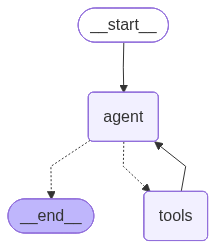

In [29]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState , StateGraph, START, END 
from langgraph.prebuilt import tools_condition

#crear el nodo de herramientas 
tool_node = ToolNode([multiply, sum])

#funcion para el llm 
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}  # ← FIX: Debe ser una lista

#construir el grafo 
builder= StateGraph(MessagesState)
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START,"agent")
builder.add_conditional_edges("agent",tools_condition)
builder.add_edge("tools","agent")

tool_graph = builder.compile()
display(Image(tool_graph.get_graph().draw_mermaid_png()))  # ← FIX: tool_graph en vez de graph

In [27]:
messages = tool_graph.invoke({"messages":[HumanMessage(content="cual es el multiplo de 2 y 3")]})
for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

cual es el multiplo de 2 y 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_NiQMDWXHFIJM0L6IcbOgvQid)
 Call ID: call_NiQMDWXHFIJM0L6IcbOgvQid
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

El múltiplo de 2 y 3 es 6.


In [28]:
messages = tool_graph.invoke({"messages":[HumanMessage(content="cual es la resta de 2 y 3")]})
for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

cual es la resta de 2 y 3
================================== Ai Message ==================================

La resta de 2 y 3 es: 

\[ 2 - 3 = -1 \]

Si necesitas que realice la operación de otra forma, házmelo saber.


### 🔧 Diferencia entre LLM Tools y ToolNode

**Concepto clave:** Deben tener exactamente las mismas herramientas para que funcionen juntas:

In [ ]:
# Ejemplo de la diferencia entre LLM Tools y ToolNode

# 1. Definir TODAS las herramientas disponibles
def divide(a: int, b: int) -> float:
    """Divide a por b"""
    return a / b

def subtract(a: int, b: int) -> int:
    """Resta b de a"""
    return a - b

# Lista completa de herramientas
ALL_TOOLS = [multiply, sum, divide, subtract]

print("🧠 LLM con herramientas:")
print("- El LLM CONOCE estas herramientas:", [tool.__name__ for tool in ALL_TOOLS])
print("- El LLM puede SOLICITAR su uso")
print("- El LLM NO puede EJECUTAR las funciones")

print("\n⚙️ ToolNode con herramientas:")  
print("- ToolNode puede EJECUTAR estas herramientas:", [tool.__name__ for tool in ALL_TOOLS])
print("- ToolNode NO puede solicitar herramientas")
print("- ToolNode solo responde a tool_calls del LLM")

print("\n🤝 Deben tener las MISMAS herramientas:")
print("✅ LLM solicita 'divide' → ToolNode puede ejecutar 'divide'")
print("❌ LLM solicita 'divide' → ToolNode no tiene 'divide' = ERROR")

### MessageStates

Fortunately, LangGraph already provides a built-in state type for this: `MessagesState`.

The cool thing about this class is that it already incorporates a `reducer`. This reducer logic will take care of appending the new message to the message list.


```python
from langgraph.graph import MessagesState


### React Agent
React Agent es un agente que utiliza el enfoque de "Reasoning and Acting" (Razonamiento y Acción) para interactuar con su entorno. Este agente puede razonar sobre la información disponible, tomar decisiones basadas en ese razonamiento y luego actuar en consecuencia. En el contexto de los modelos de lenguaje y la inteligencia artificial, un React Agent puede analizar datos, formular hipótesis, y ejecutar acciones específicas para lograr objetivos definidos.


In [ ]:
##